In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests as r
%matplotlib inline

# 1. Загрузка данных и их обработка.

In [2]:
users = pd.read_csv('/datasets/users.csv')
calls = pd.read_csv('/datasets/calls.csv')
messages = pd.read_csv('/datasets/messages.csv')
internet = pd.read_csv('/datasets/internet.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
# Загружаем данные

*Изучаем общую информацию и чистим данные.*

* Users

In [3]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [4]:
print("Число строк в users:", users.shape[0])
print("Число уникальных пользователей:", users['user_id'].count())
print("Число дубликатов:", users.duplicated().sum())
# Пользователи уникальны, дубликатов нет.

Число строк в users: 500
Число уникальных пользователей: 500
Число дубликатов: 0


In [5]:
users.info()
# Очень много пропусков в столбце churn_date. Моё предположение, что на момент выгрузки датафрейма тариф еще работал.
# Поэтому оставим данные в этом столбце как есть.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [6]:
# функция определения времени года.
def get_season(date):
    if date.month in [1, 2, 12]:
        return 'зима'
    elif date.month in [3, 4, 5]:
        return 'весна'
    elif date.month in [6, 7, 8]:
        return 'лето'
    else:
        return 'осень'

    
# переводим столбец в формат datetime + добавляем столбцы "месяц" и "время года".
def date_to_dt_month_season(dataframes):
    for df in dataframes:
        for column in df.columns:
            if 'date' in column and column != 'churn_date':
                df[column] = pd.to_datetime(df[column], format='%Y-%m-%d')
                df['месяц'] = df[column].apply(lambda x: x.month)
                df['время года'] = df[column].apply(get_season)

* Calls

In [7]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [8]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


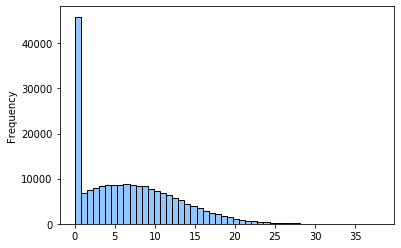

In [9]:
plt.style.use('seaborn-pastel')
calls['duration'].plot(kind='hist', ec='black', bins=50)
# Смотрим гистограмму распределения длительности звонков.

In [10]:
calls['duration'] = calls['duration'].apply(np.ceil)
calls.head()
# Округляем в большую сторону до минуты все звонки.

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.0,1000
1,1000_1,2018-08-17,0.0,1000
2,1000_2,2018-06-11,3.0,1000
3,1000_3,2018-09-21,14.0,1000
4,1000_4,2018-12-15,6.0,1000


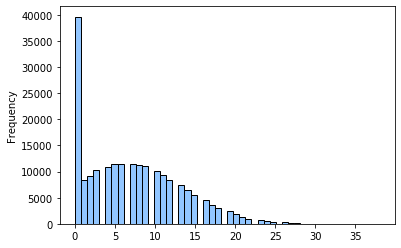

In [11]:
calls['duration'].plot(kind='hist', ec='black', bins=50)

In [12]:
calls.query('duration == 0.0')
# Нереально большое кол-во нулевых звонков. 
# Предполагаю, что это несостоявшиеся звонки. Нулевая их длительность вызвана прерыванием связи или случаями, 
# когда у другого абонента было "занято"

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.0,1000
1,1000_1,2018-08-17,0.0,1000
5,1000_5,2018-11-02,0.0,1000
6,1000_6,2018-10-18,0.0,1000
9,1000_9,2018-08-15,0.0,1000
...,...,...,...,...
202590,1499_203,2018-12-03,0.0,1499
202592,1499_205,2018-10-13,0.0,1499
202593,1499_206,2018-12-26,0.0,1499
202594,1499_207,2018-10-28,0.0,1499


In [13]:
calls['duration'] = calls['duration'].replace(0, np.NaN)
calls = calls.dropna()
# Удаляем эти строки.

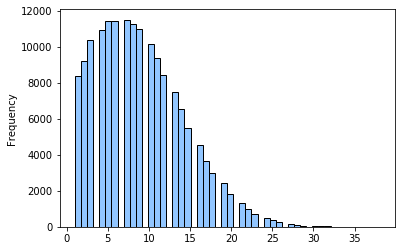

In [14]:
calls['duration'].plot(kind='hist', ec='black', bins=50)

* Messages

In [15]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [16]:
messages.info()
# Данные полные, пропусков нет.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


* Internet

In [17]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [18]:
internet.info()
# Данные полные, пропусков нет.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [19]:
internet['mb_used'] = internet['mb_used'].apply(np.ceil)
internet.head()
# Окргуляем данные в большую сторону до мегабайта.

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,113.0,2018-11-25,1000
1,1,1000_1,1053.0,2018-09-07,1000
2,2,1000_2,1198.0,2018-06-25,1000
3,3,1000_3,551.0,2018-08-22,1000
4,4,1000_4,303.0,2018-09-24,1000


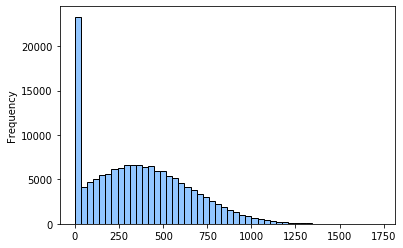

In [20]:
internet['mb_used'].plot(kind='hist', ec='black', bins=50)
# Смотрим на гистограмму распределения использования трафика.

In [21]:
internet.query('mb_used == 0')
# Смотрим на нулевой трафик.
# Очень много пропусков, скорее всего это связано с включенным интернетом, но отсутствием операций, которые тратят трафик.

,Unnamed: 0,id,mb_used,session_date,user_id
11,11,1000_11,0.0,2018-08-28,1000
38,38,1000_38,0.0,2018-11-27,1000
46,46,1000_46,0.0,2018-06-30,1000
67,67,1000_67,0.0,2018-06-16,1000
72,72,1000_72,0.0,2018-06-15,1000
...,...,...,...,...,...
149380,149380,1499_141,0.0,2018-12-11,1499
149381,149381,1499_142,0.0,2018-11-01,1499
149383,149383,1499_144,0.0,2018-11-27,1499
149386,149386,1499_147,0.0,2018-10-21,1499


In [22]:
internet['mb_used'] = internet['mb_used'].replace(0, np.NaN)
internet = internet.dropna()
# Удаляем данные.

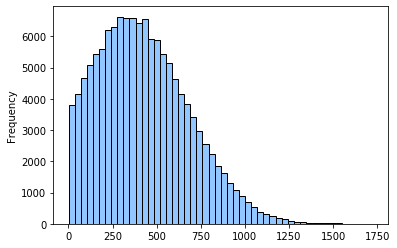

In [23]:
internet['mb_used'].plot(kind='hist', ec='black', bins=50)

* Tariffs

In [24]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


*Изменение типов столбцов и добавление столбцов "год", "месяц","время года" для каждого датафрейма.*

In [25]:
date_to_dt_month_season([users, calls, messages, internet])

In [26]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,месяц,время года
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,весна
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,11,осень
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,6,лето
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,8,лето
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,5,весна


In [27]:
calls.head()

,id,call_date,duration,user_id,месяц,время года
2,1000_2,2018-06-11,3.0,1000,6,лето
3,1000_3,2018-09-21,14.0,1000,9,осень
4,1000_4,2018-12-15,6.0,1000,12,зима
7,1000_7,2018-08-22,19.0,1000,8,лето
8,1000_8,2018-09-15,19.0,1000,9,осень


In [28]:
messages.head()

,id,message_date,user_id,месяц,время года
0,1000_0,2018-06-27,1000,6,лето
1,1000_1,2018-10-08,1000,10,осень
2,1000_2,2018-08-04,1000,8,лето
3,1000_3,2018-06-16,1000,6,лето
4,1000_4,2018-12-05,1000,12,зима


In [29]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id,месяц,время года
0,0,1000_0,113.0,2018-11-25,1000,11,осень
1,1,1000_1,1053.0,2018-09-07,1000,9,осень
2,2,1000_2,1198.0,2018-06-25,1000,6,лето
3,3,1000_3,551.0,2018-08-22,1000,8,лето
4,4,1000_4,303.0,2018-09-24,1000,9,осень


Даты сделали как надо.

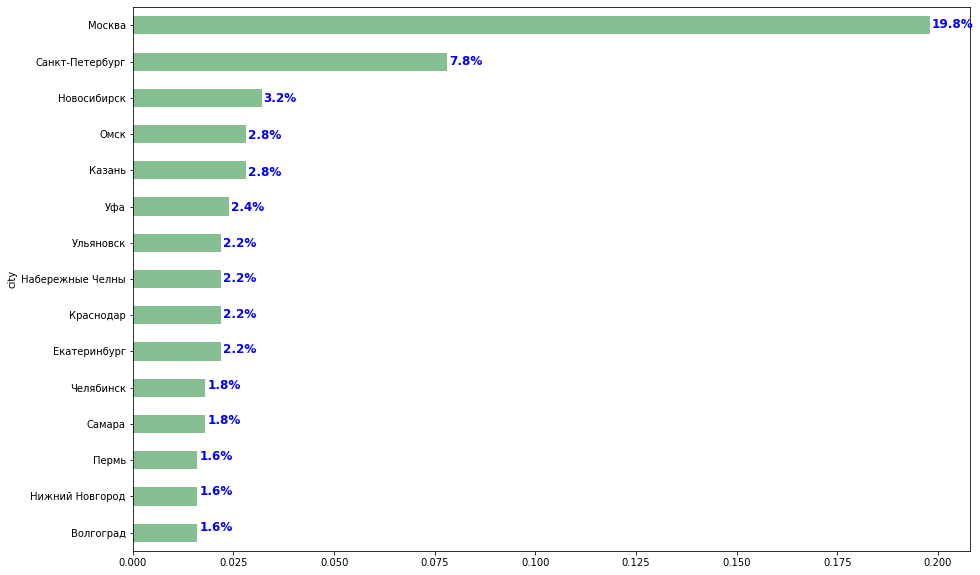

In [30]:
all_users = len(users)
df_for_barh = users.groupby('city').size()/all_users
df_for_barh_filtered = df_for_barh[df_for_barh > 0.015].sort_values()
ax = df_for_barh_filtered.plot(kind='barh', color='#86bf91', figsize=(15,10))

labels = dict(df_for_barh_filtered)
labels

i = 0
for city in labels:
    ax.text(labels[city] + 0.0005, i + 0.05, str(round(labels[city]*100, 2)) + '%', 
            fontsize = 'large', fontweight='bold', color='blue')
    if i < 9.7:
        i += 0.98
    else:
        i += 1.02
# Рассматриваем города пользователей.
# Значительное преобладание Москвичей(почти 20%), Петербуржцы(почти 8%), остальные города до 3%.

*Выясним, каким типом связи абоненты пользуются чаще всего.*

*Воспользуемся яндекс геокодером и сформируем уникальный список городов.*

In [31]:
list_of_cities = users['city'].unique().tolist()

In [32]:
url = 'https://geocode-maps.yandex.ru/1.x/?format=json&apikey=85937294-3135-43a5-b812-70f0ac01f935&geocode='
coordinates = []

for city in list_of_cities:
    if city == city: # чтоб не столкнуться с nan
        url_formatted = url + city
        response = r.get(url_formatted).json()
        data = response['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['Point'].get('pos')
        coordinate = (float(data.split()[1]), float(data.split()[0]))
        coordinates.append(coordinate)
    else:
        coordinates.append('')

In [33]:
unique_cities_coordinates = pd.DataFrame({'Город':list_of_cities, 'Координаты':coordinates})
unique_cities_coordinates.head(10)

,Город,Координаты
0,Краснодар,"(45.03547, 38.975313)"
1,Москва,"(55.753215, 37.622504)"
2,Стерлитамак,"(53.630403, 55.930825)"
3,Новокузнецк,"(53.757547, 87.136044)"
4,Набережные Челны,"(55.740776, 52.406384)"
5,Ульяновск,"(54.314192, 48.403123)"
6,Челябинск,"(55.159897, 61.402554)"
7,Пермь,"(58.01045, 56.229434)"
8,Тюмень,"(57.153033, 65.534328)"
9,Самара,"(53.195538, 50.101783)"


In [34]:
dict_unique_cities_coordinates = dict(pd.Series(unique_cities_coordinates['Координаты'].values,
                                index=unique_cities_coordinates['Город'].values))
users['coordinates'] = users['city'].map(dict_unique_cities_coordinates) 
# Сделаем словарь, чтобы добавить координаты в основной датафрейм

In [35]:
users['Latitude'] = users['coordinates'].apply(lambda x: x[0])
users['Longitude'] = users['coordinates'].apply(lambda x: x[1])
users = users.drop(['coordinates'], axis=1) # Широту и долготу отделим в разные столбцы

In [36]:
users.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,месяц,время года,Latitude,Longitude
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,весна,45.035470,38.975313
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,11,осень,55.753215,37.622504
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,6,лето,53.630403,55.930825
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,8,лето,55.753215,37.622504
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,5,весна,53.757547,87.136044
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,1,зима,55.740776,52.406384
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart,2,зима,54.314192,48.403123
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart,4,весна,55.753215,37.622504
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart,12,зима,55.159897,61.402554
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart,3,весна,58.010450,56.229434


*Выясним, каким типом связи абоненты пользуются чаще всего*

In [37]:
def barplot_by_month(dfs, query=None):
    list_of_dfs = dfs
    plt.figure(figsize=(15,5))
    ax = plt.gca()
    
    list_of_colors = ['forestgreen', 'grey', 'mediumaquamarine']

    dfs_names_for_legend = ['Звонки', 'СМС', 'Выходы в интернет']
    legend_list = []

    for i in range(len(list_of_dfs)):
        curr_df = list_of_dfs[i]
        if query == None:
            curr_df_prepared = curr_df.groupby('месяц')['id'].count().reset_index()
        else:
            curr_df_prepared = curr_df.query(query).groupby('месяц')['id'].count().reset_index()
        plot = curr_df_prepared.plot(x='месяц', y='id', kind='bar', ec='black', color=list_of_colors[i],
                                 ax=ax, width=0.1, position=i)
        legend_list.append(dfs_names_for_legend[i])
    plt.xticks(rotation=0)
    ax.legend(legend_list)

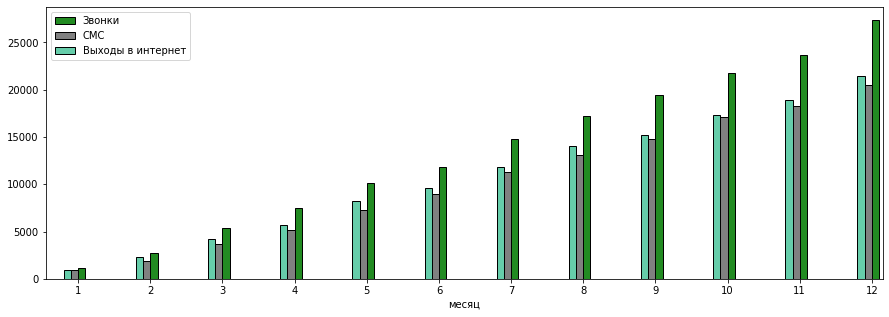

In [38]:
barplot_by_month([calls, messages, internet])

Кажется, что оператор вышел на рынок совсем недавно. Очень сильный рост, и мы оцениваем его работу за год.

# 2. Помесячная выручка с каждого пользователя.

Посчитаем для каждого пользователя:

* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

In [39]:
num_of_calls = calls.groupby(['user_id', 'время года', 'месяц'])['duration'].agg(['count', 'sum'])
num_of_messages = messages.groupby(['user_id', 'время года', 'месяц'])['id'].count()
num_of_internet = internet.groupby(['user_id', 'время года', 'месяц']).sum()['mb_used']

In [40]:
data_event_numbers = pd.concat([num_of_calls, num_of_messages, num_of_internet], axis=1)
data_event_numbers = data_event_numbers.reset_index()
data_event_numbers.head()

,user_id,время года,месяц,count,sum,id,mb_used
0,1000,весна,5,17.0,159.0,22.0,2256.0
1,1000,зима,12,38.0,333.0,70.0,9827.0
2,1000,лето,6,28.0,172.0,60.0,23257.0
3,1000,лето,7,41.0,340.0,75.0,14016.0
4,1000,лето,8,42.0,408.0,81.0,14070.0


In [41]:
map_to_fill_tariff = dict(pd.Series(users['tariff'].values, index=users['user_id']))
data_event_numbers['Тариф'] = data_event_numbers['user_id'].map(map_to_fill_tariff)

map_to_fill_city = dict(pd.Series(users['city'].values, index=users['user_id']))
data_event_numbers['Город'] = data_event_numbers['user_id'].map(map_to_fill_city)

map_to_fill_Latitude = dict(pd.Series(users['Latitude'].values, index=users['user_id']))
data_event_numbers['Latitude'] = data_event_numbers['user_id'].map(map_to_fill_Latitude)

map_to_fill_Longitude = dict(pd.Series(users['Longitude'].values, index=users['user_id']))
data_event_numbers['Longitude'] = data_event_numbers['user_id'].map(map_to_fill_Longitude)
# Добавляем столбцы с тарифом, долготой, широтой и городом

In [42]:
data_event_numbers.columns = ['User_id', 'Время года', 'Месяц', 'Кол-во звонков, шт.', 'Звонки, мин.', 
                            'СМС, шт.', 'Интернет, Мб', 'Тариф', 'Город', 'Широта', 'Долгота']
# Для удобства

In [43]:
data_event_numbers.sort_values(by=['User_id', 'Месяц']).head(10)

,User_id,Время года,Месяц,"Кол-во звонков, шт.","Звонки, мин.","СМС, шт.","Интернет, Мб",Тариф,Город,Широта,Долгота
0,1000,весна,5,17.0,159.0,22.0,2256.0,ultra,Краснодар,45.035470,38.975313
2,1000,лето,6,28.0,172.0,60.0,23257.0,ultra,Краснодар,45.035470,38.975313
3,1000,лето,7,41.0,340.0,75.0,14016.0,ultra,Краснодар,45.035470,38.975313
4,1000,лето,8,42.0,408.0,81.0,14070.0,ultra,Краснодар,45.035470,38.975313
5,1000,осень,9,46.0,466.0,57.0,14581.0,ultra,Краснодар,45.035470,38.975313
6,1000,осень,10,44.0,350.0,73.0,14717.0,ultra,Краснодар,45.035470,38.975313
7,1000,осень,11,37.0,338.0,58.0,14768.0,ultra,Краснодар,45.035470,38.975313
1,1000,зима,12,38.0,333.0,70.0,9827.0,ultra,Краснодар,45.035470,38.975313
9,1001,осень,11,45.0,430.0,NaN,18452.0,smart,Москва,55.753215,37.622504
8,1001,зима,12,47.0,414.0,NaN,14053.0,smart,Москва,55.753215,37.622504


In [44]:
data_event_numbers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 11 columns):
User_id                3214 non-null int64
Время года             3214 non-null object
Месяц                  3214 non-null int64
Кол-во звонков, шт.    3168 non-null float64
Звонки, мин.           3168 non-null float64
СМС, шт.               2717 non-null float64
Интернет, Мб           3201 non-null float64
Тариф                  3214 non-null object
Город                  3214 non-null object
Широта                 3214 non-null float64
Долгота                3214 non-null float64
dtypes: float64(6), int64(2), object(3)
memory usage: 276.3+ KB


In [45]:
data_event_numbers[data_event_numbers['Интернет, Мб'].isnull()]

,User_id,Время года,Месяц,"Кол-во звонков, шт.","Звонки, мин.","СМС, шт.","Интернет, Мб",Тариф,Город,Широта,Долгота
592,1094,весна,5,12.0,107.0,3.0,NaN,ultra,Новосибирск,55.030199,82.920430
1722,1273,весна,5,19.0,220.0,21.0,NaN,ultra,Курган,55.441004,65.341118
1723,1273,зима,12,38.0,260.0,39.0,NaN,ultra,Курган,55.441004,65.341118
1724,1273,лето,6,28.0,230.0,38.0,NaN,ultra,Курган,55.441004,65.341118
1725,1273,лето,7,30.0,253.0,37.0,NaN,ultra,Курган,55.441004,65.341118
1726,1273,лето,8,39.0,253.0,41.0,NaN,ultra,Курган,55.441004,65.341118
1727,1273,осень,9,28.0,223.0,32.0,NaN,ultra,Курган,55.441004,65.341118
1728,1273,осень,10,35.0,315.0,35.0,NaN,ultra,Курган,55.441004,65.341118
1729,1273,осень,11,31.0,272.0,29.0,NaN,ultra,Курган,55.441004,65.341118
2307,1365,осень,10,5.0,43.0,1.0,NaN,smart,Ростов-на-Дону,47.222078,39.720349


*Заполнение пропусков:*

In [46]:
data_event_numbers[(data_event_numbers['Интернет, Мб'].isnull()) & (data_event_numbers['СМС, шт.'].isnull()) &
                 (data_event_numbers['Звонки, мин.'].isnull())]

,User_id,Время года,Месяц,"Кол-во звонков, шт.","Звонки, мин.","СМС, шт.","Интернет, Мб",Тариф,Город,Широта,Долгота


In [47]:
data_event_numbers = data_event_numbers.fillna(0)

In [48]:
data_event_numbers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 11 columns):
User_id                3214 non-null int64
Время года             3214 non-null object
Месяц                  3214 non-null int64
Кол-во звонков, шт.    3214 non-null float64
Звонки, мин.           3214 non-null float64
СМС, шт.               3214 non-null float64
Интернет, Мб           3214 non-null float64
Тариф                  3214 non-null object
Город                  3214 non-null object
Широта                 3214 non-null float64
Долгота                3214 non-null float64
dtypes: float64(6), int64(2), object(3)
memory usage: 276.3+ KB


*Смотрим, какая часть клиентов использует тот или иной тариф:*

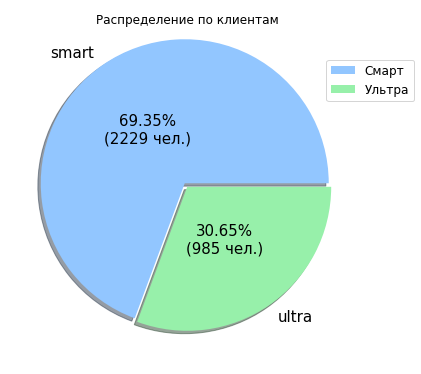

In [49]:
all_users = data_event_numbers['User_id'].count()


def func_pct(pct):
    value = float(pct/100.*all_users)
    return "{:.2f}%\n({:.0f} чел.)".format(pct, value)

explode = (0.03, 0)

axes = data_event_numbers.groupby('Тариф')['User_id'].count().plot(kind='pie', subplots=True, fontsize=15,
                                                                     use_index=False, shadow=True, explode=explode,
                                                                     title = 'Распределение по клиентам', pctdistance=0.45,
                                                                     figsize=(20,5), autopct=lambda pct: func_pct(pct))

plt.tight_layout(pad=0)

for ax in axes:
    ax.legend(['Смарт', 'Ультра'], bbox_to_anchor=(0.87,0.87), prop={'size':12})
    ax.set_ylabel('')

*Смотрим каким способом связи пользуются в каждом из тарифов:*

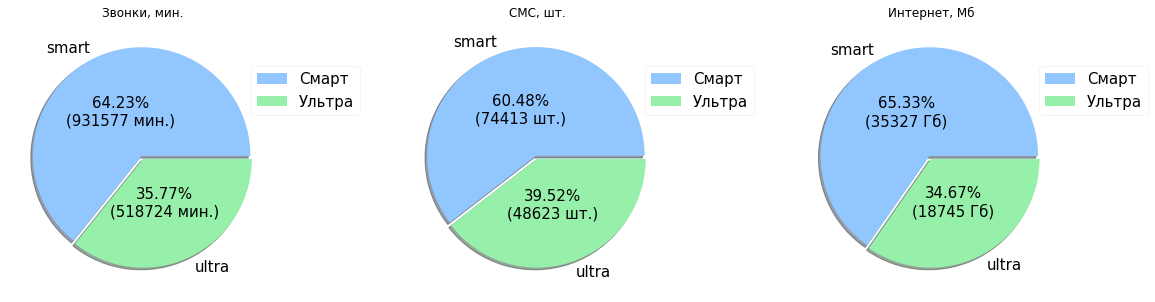

In [50]:
columns_to_plot = ['Звонки, мин.', 'СМС, шт.', 'Интернет, Мб']

calls_sum = data_event_numbers['Звонки, мин.'].sum()
sms_sum = data_event_numbers['СМС, шт.'].sum()
internet_sum = data_event_numbers['Интернет, Мб'].sum()

def func_pct(pct):
    if pct > 65 or pct < 35:
        sum_of_data = internet_sum
        value = float(pct/100.*sum_of_data/1024)
        metric = 'Гб'
    elif pct > 64 or pct < 36:
        sum_of_data = calls_sum
        value = float(pct/100.*sum_of_data)
        metric = 'мин.'
    else:
        sum_of_data = sms_sum
        value = float(pct/100.*sum_of_data)
        metric = 'шт.'
    return "{:.2f}%\n({:.0f} {})".format(pct, value, metric)

explode = (0.03, 0)

axes = data_event_numbers.groupby('Тариф')[columns_to_plot].sum().plot(kind='pie', subplots=True, fontsize=15,
                                                                       use_index=False, shadow=True, explode=explode,
                                                                       title = columns_to_plot, pctdistance=0.45,
                                                                       autopct=lambda pct: func_pct(pct), figsize=(20,5))

for ax in axes:
    ax.legend(['Смарт', 'Ультра'], framealpha=0.2, bbox_to_anchor=(0.87,0.87), prop={'size':15})
    ax.set_ylabel('')

In [51]:
month_price = {'smart': 550, 'ultra': 1950}
data_event_numbers['Аб. плата, руб.'] = data_event_numbers['Тариф'].map(month_price)
# Сделаем словарь с новыми данными

In [52]:
data_event_numbers.head()

,User_id,Время года,Месяц,"Кол-во звонков, шт.","Звонки, мин.","СМС, шт.","Интернет, Мб",Тариф,Город,Широта,Долгота,"Аб. плата, руб."
0,1000,весна,5,17.0,159.0,22.0,2256.0,ultra,Краснодар,45.03547,38.975313,1950
1,1000,зима,12,38.0,333.0,70.0,9827.0,ultra,Краснодар,45.03547,38.975313,1950
2,1000,лето,6,28.0,172.0,60.0,23257.0,ultra,Краснодар,45.03547,38.975313,1950
3,1000,лето,7,41.0,340.0,75.0,14016.0,ultra,Краснодар,45.03547,38.975313,1950
4,1000,лето,8,42.0,408.0,81.0,14070.0,ultra,Краснодар,45.03547,38.975313,1950


*Посчитаем использование всех видов связи сверх лимита:*

In [53]:
def calls_over_plan(row):
    if row['Тариф'] == 'smart':
        result = row['Звонки, мин.'] - 500
        return np.where(result > 0, result, 0)
    else:
        result = row['Звонки, мин.'] - 3000
        return np.where(result > 0, result, 0)
    
    
def sms_over_plan(row):
    if row['Тариф'] == 'smart':
        result = row['СМС, шт.'] - 50
        return np.where(result > 0, result, 0)
    else:
        result =  row['СМС, шт.'] - 1000
        return np.where(result > 0, result, 0)
    

def internet_over_plan(row):
    if row['Тариф'] == 'smart':
        result = row['Интернет, Мб'] - 15 * 1024
        return np.where(result > 0, result, 0)
    else:
        result = row['Интернет, Мб'] - 30 * 1024
        return np.where(result > 0, result, 0)
    
    
def month_revenue(row):
    sum_per_month = 0
    if row['Тариф'] == 'smart':
        sum_per_month += np.ceil(row['Минуты сверх']) * 3
        sum_per_month += row['СМС сверх'] * 3
        sum_per_month += np.ceil(row['Мб сверх']/1024) * 200
        return sum_per_month
    
    else:
        sum_per_month += np.ceil(row['Минуты сверх']) * 1
        sum_per_month += row['СМС сверх'] * 1
        sum_per_month += np.ceil(row['Мб сверх']/1024) * 150
        return sum_per_month

In [54]:
data_event_numbers['Минуты сверх'] = data_event_numbers.apply(calls_over_plan, axis=1)
data_event_numbers['СМС сверх'] = data_event_numbers.apply(sms_over_plan, axis=1)
data_event_numbers['Мб сверх'] = data_event_numbers.apply(internet_over_plan, axis=1)

data_event_numbers['Плата сверх лимита, руб.'] = data_event_numbers.apply(month_revenue, axis=1)

for column in ['Минуты сверх', 'Мб сверх']:
    data_event_numbers[column] = data_event_numbers[column].astype('float')

for column in ['СМС сверх', 'Плата сверх лимита, руб.']:
    data_event_numbers[column] = data_event_numbers[column].astype('int')
# Добавим новые стобцы.

In [55]:
data_event_numbers.head(10)

,User_id,Время года,Месяц,"Кол-во звонков, шт.","Звонки, мин.","СМС, шт.","Интернет, Мб",Тариф,Город,Широта,Долгота,"Аб. плата, руб.",Минуты сверх,СМС сверх,Мб сверх,"Плата сверх лимита, руб."
0,1000,весна,5,17.0,159.0,22.0,2256.0,ultra,Краснодар,45.035470,38.975313,1950,0.0,0,0.0,0
1,1000,зима,12,38.0,333.0,70.0,9827.0,ultra,Краснодар,45.035470,38.975313,1950,0.0,0,0.0,0
2,1000,лето,6,28.0,172.0,60.0,23257.0,ultra,Краснодар,45.035470,38.975313,1950,0.0,0,0.0,0
3,1000,лето,7,41.0,340.0,75.0,14016.0,ultra,Краснодар,45.035470,38.975313,1950,0.0,0,0.0,0
4,1000,лето,8,42.0,408.0,81.0,14070.0,ultra,Краснодар,45.035470,38.975313,1950,0.0,0,0.0,0
5,1000,осень,9,46.0,466.0,57.0,14581.0,ultra,Краснодар,45.035470,38.975313,1950,0.0,0,0.0,0
6,1000,осень,10,44.0,350.0,73.0,14717.0,ultra,Краснодар,45.035470,38.975313,1950,0.0,0,0.0,0
7,1000,осень,11,37.0,338.0,58.0,14768.0,ultra,Краснодар,45.035470,38.975313,1950,0.0,0,0.0,0
8,1001,зима,12,47.0,414.0,0.0,14053.0,smart,Москва,55.753215,37.622504,550,0.0,0,0.0,0
9,1001,осень,11,45.0,430.0,0.0,18452.0,smart,Москва,55.753215,37.622504,550,0.0,0,3092.0,800


*Посчитаем сумму за месяц и добавим новый столбец:*

In [56]:
data_event_numbers['Сумма за месяц, руб.'] = data_event_numbers['Аб. плата, руб.'] + data_event_numbers['Плата сверх лимита, руб.']

In [57]:
data_event_numbers.head(10)

,User_id,Время года,Месяц,"Кол-во звонков, шт.","Звонки, мин.","СМС, шт.","Интернет, Мб",Тариф,Город,Широта,Долгота,"Аб. плата, руб.",Минуты сверх,СМС сверх,Мб сверх,"Плата сверх лимита, руб.","Сумма за месяц, руб."
0,1000,весна,5,17.0,159.0,22.0,2256.0,ultra,Краснодар,45.035470,38.975313,1950,0.0,0,0.0,0,1950
1,1000,зима,12,38.0,333.0,70.0,9827.0,ultra,Краснодар,45.035470,38.975313,1950,0.0,0,0.0,0,1950
2,1000,лето,6,28.0,172.0,60.0,23257.0,ultra,Краснодар,45.035470,38.975313,1950,0.0,0,0.0,0,1950
3,1000,лето,7,41.0,340.0,75.0,14016.0,ultra,Краснодар,45.035470,38.975313,1950,0.0,0,0.0,0,1950
4,1000,лето,8,42.0,408.0,81.0,14070.0,ultra,Краснодар,45.035470,38.975313,1950,0.0,0,0.0,0,1950
5,1000,осень,9,46.0,466.0,57.0,14581.0,ultra,Краснодар,45.035470,38.975313,1950,0.0,0,0.0,0,1950
6,1000,осень,10,44.0,350.0,73.0,14717.0,ultra,Краснодар,45.035470,38.975313,1950,0.0,0,0.0,0,1950
7,1000,осень,11,37.0,338.0,58.0,14768.0,ultra,Краснодар,45.035470,38.975313,1950,0.0,0,0.0,0,1950
8,1001,зима,12,47.0,414.0,0.0,14053.0,smart,Москва,55.753215,37.622504,550,0.0,0,0.0,0,550
9,1001,осень,11,45.0,430.0,0.0,18452.0,smart,Москва,55.753215,37.622504,550,0.0,0,3092.0,800,1350


Даже по первым строчкам видно, что есть клиенты превышающие лимиты своего тарифа.

In [58]:
data_event_numbers['Не хватило тарифного плана'] = np.where(data_event_numbers['Плата сверх лимита, руб.'] > 0, 1, 0)

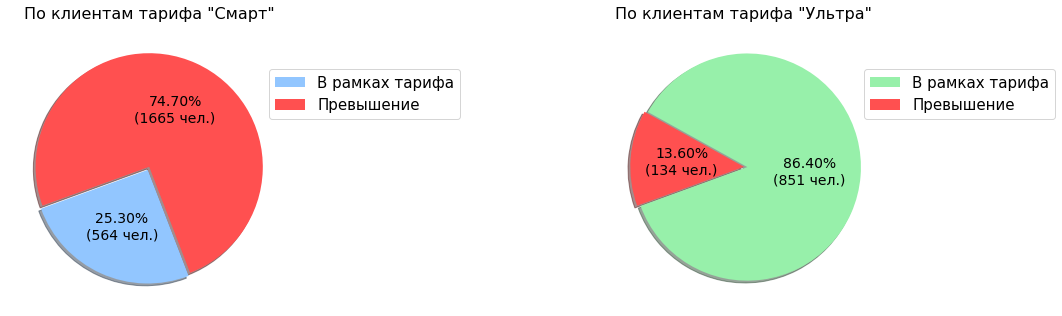

In [59]:
filter_list = ['smart', 'ultra']
titles_list = ['По клиентам тарифа "Смарт"', 'По клиентам тарифа "Ультра"']
rows = 1
cols = 2
filter_list_counter = 0

sum_smart = data_event_numbers[data_event_numbers['Тариф'] == 'smart'].count()['User_id']
sum_ultra = data_event_numbers[data_event_numbers['Тариф'] == 'ultra'].count()['User_id']

annot_labels = ['В рамках тарифа', 'Дозаказ услуг']

def func_pct(pct):
    if pct < 75 and pct > 25:
        value = float(pct/100.*sum_smart)
    else:
        value = float(pct/100.*sum_ultra)
    return "{:.2f}%\n({:.0f} чел.)".format(pct, value)

fig, axes = plt.subplots(rows, cols, figsize=(20,10))

explode = (0.03, 0) 

for r in range(rows):
    for c in range(cols):
        if filter_list[filter_list_counter] == 'smart':
            colors = ['#92c6ff', '#ff5050']
        else:
            colors = ['#97F0AA', '#ff5050']
        curr_filtered_df = data_event_numbers[data_event_numbers['Тариф'] == filter_list[filter_list_counter]].groupby('Не хватило тарифного плана')['User_id']
        ax = curr_filtered_df.count().plot(kind='pie', fontsize=14, use_index=False, shadow=True, explode=explode,
                                           title=titles_list[filter_list_counter], pctdistance=0.55, figsize=(20,5),
                                           autopct=lambda pct: func_pct(pct), startangle=200, ax=axes[c], colors=colors,
                                           labels=None)

        filter_list_counter += 1

plt.tight_layout(pad=3)

for ax in axes:
    ax.legend(['В рамках тарифа', 'Превышение'], bbox_to_anchor=(0.897,0.87), prop={'size':15})
    ax.set_ylabel('')
    ax.title.set_size(16)
    ax.title.set_position([0.5, 1.15])

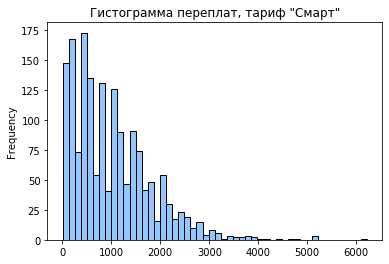

In [60]:
title = 'Гистограмма переплат, тариф "Смарт"'
data_filtered = data_event_numbers[(data_event_numbers['Тариф'] == 'smart') & 
                               (data_event_numbers['Плата сверх лимита, руб.'] > 0)]['Плата сверх лимита, руб.']
data_filtered.plot(kind='hist', title=title, ec='black', bins=50)
# Сделаем гистограмму переплат тарифа Смарт

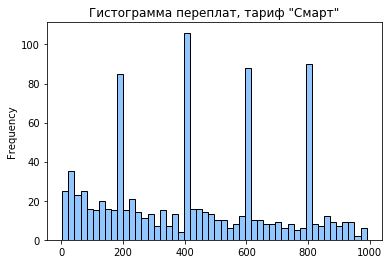

In [61]:
title = 'Гистограмма переплат, тариф "Смарт"'
data_filtered_less1000 = data_event_numbers[(data_event_numbers['Тариф'] == 'smart') & 
                                        (data_event_numbers['Плата сверх лимита, руб.'] > 0) &
                                        (data_event_numbers['Плата сверх лимита, руб.'] < 1000)]['Плата сверх лимита, руб.']
data_filtered_less1000.plot(kind='hist', title=title, ec='black', bins=50)

На смарте люди часто переплачивают сумму, кратную 200 рублям. Скорее всего это дополнительный гигабайт.

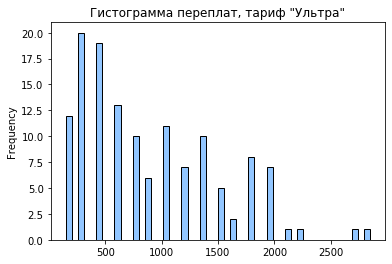

In [62]:
title = 'Гистограмма переплат, тариф "Ультра"'
data_filtered = data_event_numbers[(data_event_numbers['Тариф'] == 'ultra') & 
                               (data_event_numbers['Плата сверх лимита, руб.'] > 0)]['Плата сверх лимита, руб.']
data_filtered.plot(kind='hist', title=title, ec='black', bins=50)
# Сделаем гистограмму переплат тарифа Ультра

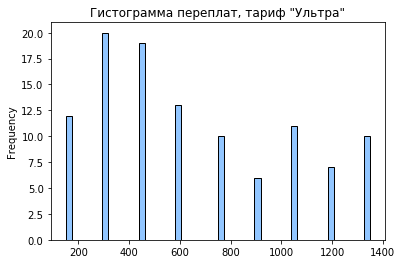

In [63]:
title = 'Гистограмма переплат, тариф "Ультра"'
data_filtered_less1000 = data_event_numbers[(data_event_numbers['Тариф'] == 'ultra') & 
                                        (data_event_numbers['Плата сверх лимита, руб.'] > 0) &
                                        (data_event_numbers['Плата сверх лимита, руб.'] < 1500)]['Плата сверх лимита, руб.']
data_filtered_less1000.plot(kind='hist', title=title, ec='black', bins=50)

Людям на обоих тарифах не хватает интернета.

In [64]:
(data_event_numbers.groupby('Тариф').sum()[['Минуты сверх', 'СМС сверх', 'Мб сверх']]).reset_index()

,Тариф,Минуты сверх,СМС сверх,Мб сверх
0,smart,92739.0,12928,6175667.0
1,ultra,0.0,0,743233.0


Пользователи Смарта тратят сверх лимита абсолютно все виды связи. На ультре же не хватает только интернета.

*Сравним суммарную выручку по кажлому из тарифов.*

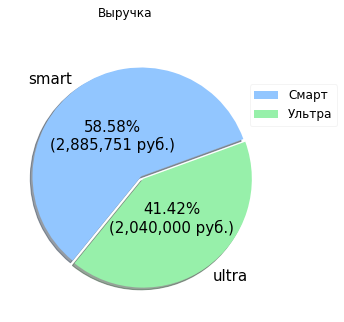

In [65]:
all_revenue = data_event_numbers['Сумма за месяц, руб.'].sum()


def func_pct(pct):
    value = float(pct/100.*all_revenue)
    return "{:.2f}%\n({:,.0f} руб.)".format(pct, value)

explode = (0.03, 0)

axes = data_event_numbers.groupby('Тариф')['Сумма за месяц, руб.'].sum().plot(kind='pie', subplots=True, fontsize=15,
                                                                     use_index=False, shadow=True, explode=explode,
                                                                     title = 'Выручка', pctdistance=0.45,
                                                                     startangle=20, figsize=(20,5),
                                                                     autopct=lambda pct: func_pct(pct))

for ax in axes:
    ax.legend(['Смарт', 'Ультра'], bbox_to_anchor=(0.87,0.87), framealpha=0.2, prop={'size':12})
    ax.set_ylabel('')

Больше людей пользуются тарифом Смарт, больше трафика проходит через тариф Смарт, больше отправляется смс и больше совершается звонков, и, как следствие, большую часть выручки приносит тариф Смарт, даже несмотря на что, что абонентская плата по тарифу Ультра в 3 раза выше.

# 3.Описание поведения клиентов оператора.

In [66]:
def plot_box(whis):
    column_list = ['Звонки, мин.', 'СМС, шт.', 'Интернет, Мб']
    rows = 1
    cols = 3
    column_list_counter = 0

    fig, axes = plt.subplots(rows, cols, figsize=(40,15))

    for r in range(rows):
        for c in range(cols):
            ax = data_event_numbers.boxplot(column=column_list[column_list_counter], by='Тариф', fontsize=40, ax=axes[c],
                                         boxprops=dict(linestyle='-', linewidth=5),
                                         medianprops=dict(linestyle='-', linewidth=5),
                                         whiskerprops=dict(linestyle='-', linewidth=5),
                                         capprops=dict(linestyle='-', linewidth=5),
                                         notch=True, whis=whis)
            ax.set_title(column_list[column_list_counter])
            ax.title.set_size(40)
            ax.set_xlabel('')
            plt.suptitle('Boxplot с whis = {}'.format(whis), y=1, fontsize=45, fontweight='bold')
            column_list_counter += 1

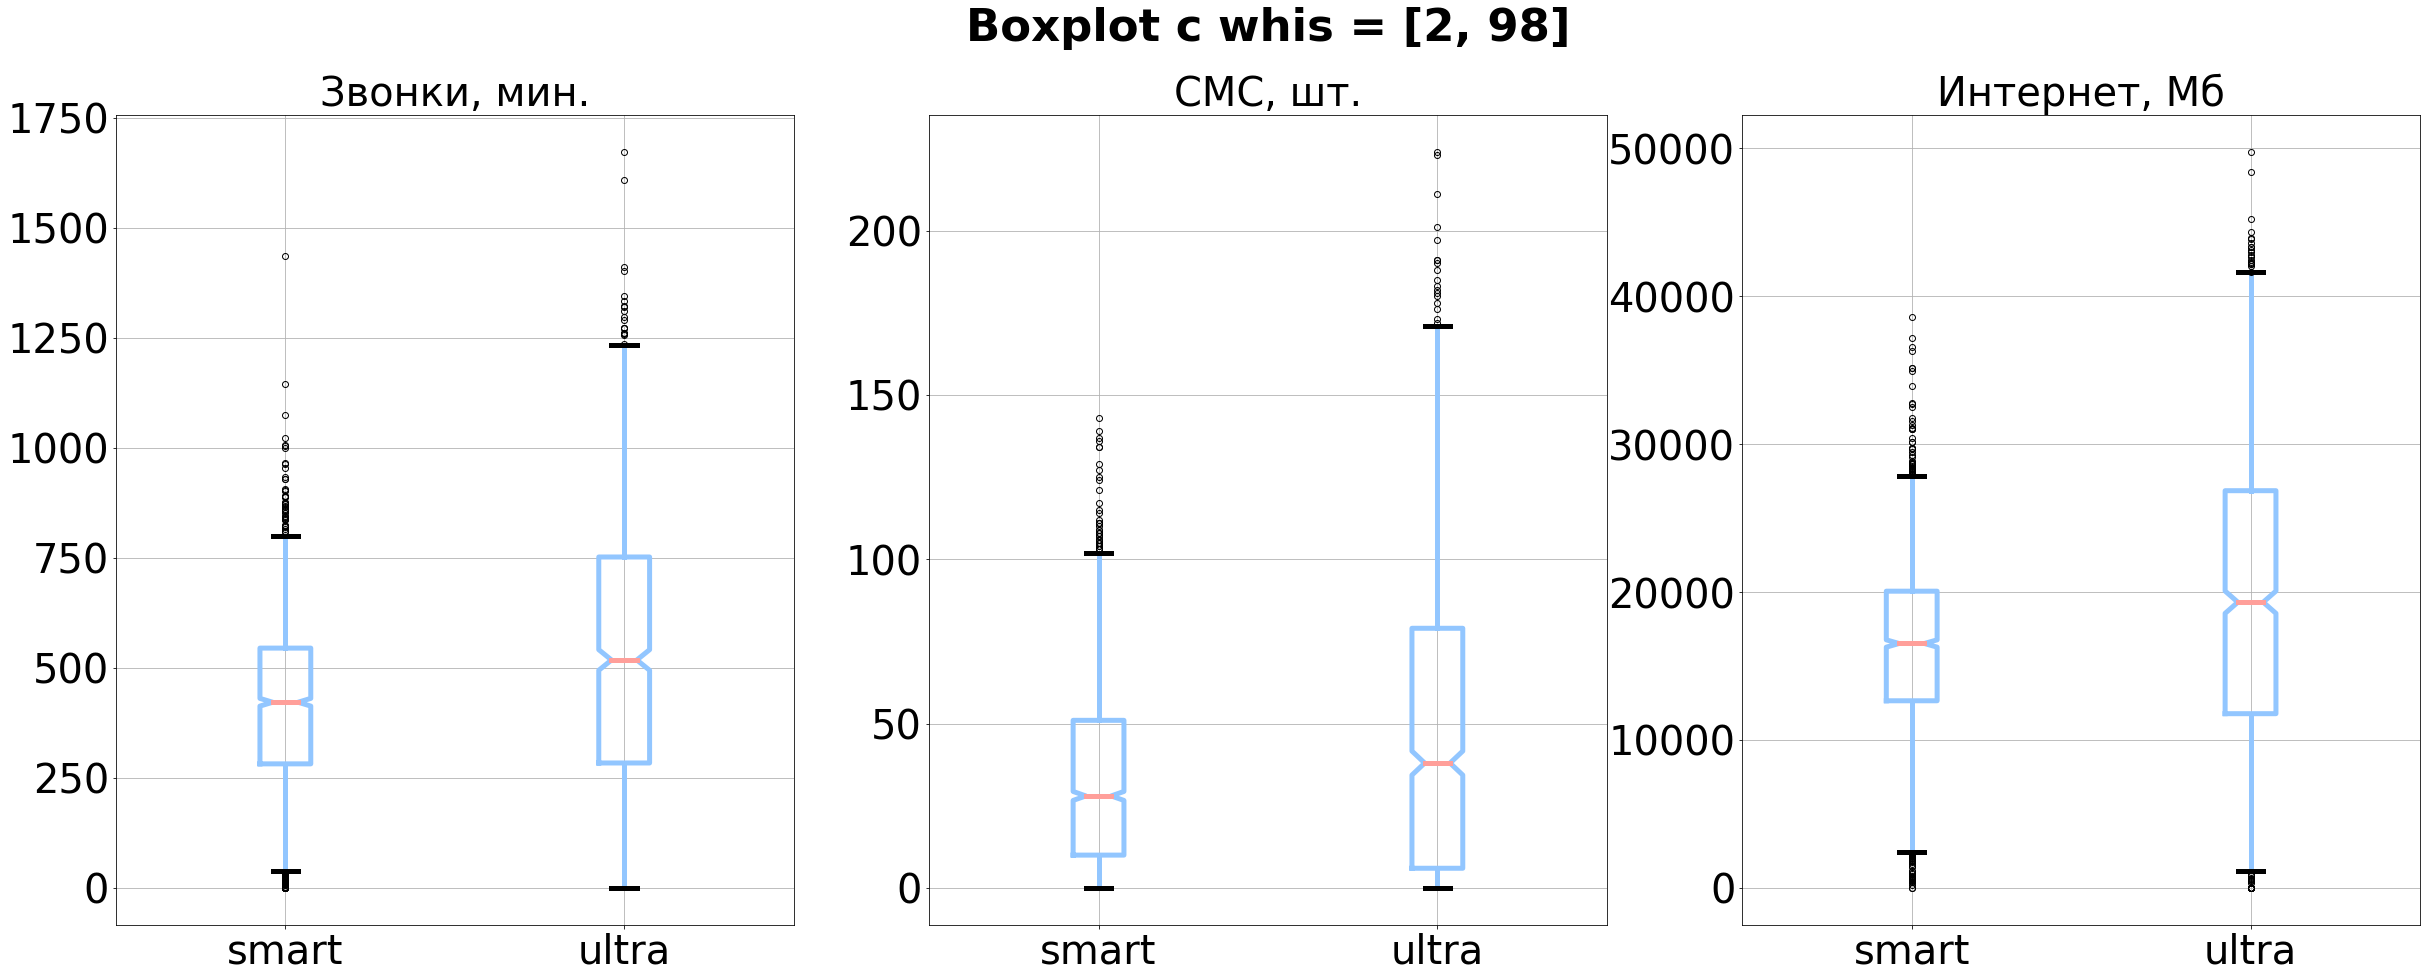

In [67]:
plot_box([2,98])

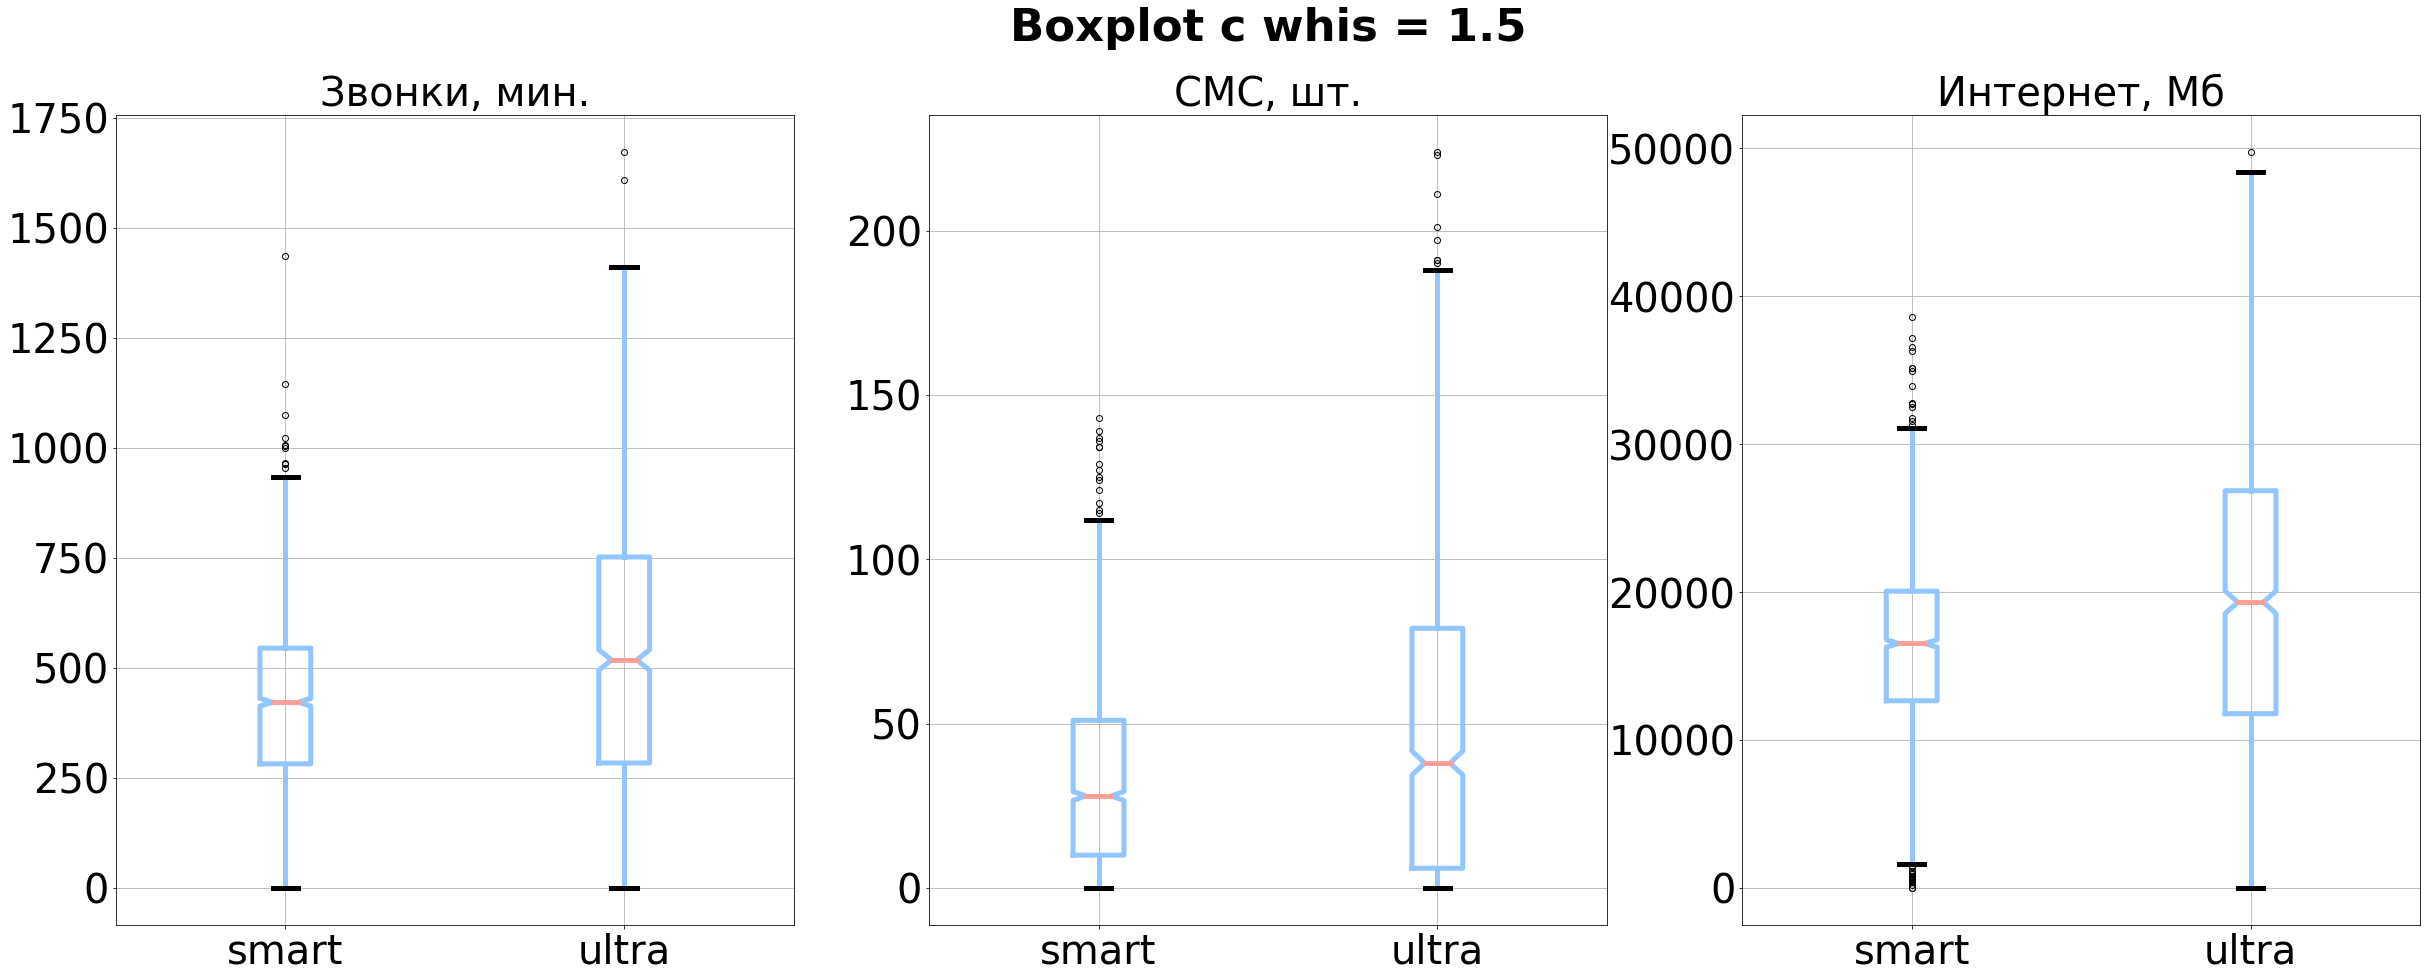

In [68]:
plot_box(1.5)

При параметре whis = 1.5 уходит гораздо меньше аномалий, данные сохраняются лучше.

In [69]:
def get_intervals(column, data_filter):
    
    if data_filter == 'Тариф':
        format_name = column
        data1, data2 = 'smart', 'ultra'
        format_end1 = 'тарифа "Смарт"'
        format_end2 = 'тарифа "Ультра"'
    elif data_filter == 'is_Moscow':
        format_name = 'is_Moscow'
        data1, data2 = 0, 1
        format_end1 = 'для регионов'
        format_end2 = 'для Москвы'
    
    q1_1 = data_event_numbers[data_event_numbers[data_filter] == data1][column].quantile(0.25)
    q3_1 = data_event_numbers[data_event_numbers[data_filter] == data1][column].quantile(0.75)
    diff_1 = q3_1 - q1_1
    
    if data_filter == 'is_Moscow':
        left_int_1 = np.where( (q1_1 - 1.5 * diff_1) > 550, q1_1 - 1.5 * diff_1, 550)
    else:
        left_int_1 = np.where( (q1_1 - 1.5 * diff_1) > 0, q1_1 - 1.5 * diff_1, 0)
    
    right_int_1 = np.where( (q3_1 + 1.5 * diff_1) > 0, q3_1 + 1.5 * diff_1, 0)
    
    q1_2 = data_event_numbers[data_event_numbers[data_filter] == data2][column].quantile(0.25)
    q3_2 = data_event_numbers[data_event_numbers[data_filter] == data2][column].quantile(0.75)
    diff_2 = q3_2 - q1_2
    
    if data_filter == 'is_Moscow':
        left_int_2 = np.where( (q1_2 - 1.5 * diff_2) > 550, q1_2 - 1.5 * diff_2, 550)
    else:
        left_int_2 = np.where( (q1_2 - 1.5 * diff_2) > 0, q1_2 - 1.5 * diff_2, 0)
        
    right_int_2 = np.where( (q3_2 + 1.5 * diff_2) > 0, q3_2 + 1.5 * diff_2, 0)
    
    print('Границы интервала для столбца "{}" {}: {} - {}'.format(column, format_end1, left_int_1, right_int_1))
    print('Границы интервала для столбца "{}" {}: {} - {}'.format(column, format_end2, left_int_2, right_int_2))
    
    return (left_int_1, right_int_1), (left_int_2, right_int_2)

In [70]:
calls_int_smart, calls_int_ultra = get_intervals('Звонки, мин.', 'Тариф')

Границы интервала для столбца "Звонки, мин." тарифа "Смарт": 0.0 - 939.5
Границы интервала для столбца "Звонки, мин." тарифа "Ультра": 0.0 - 1454.0


In [71]:
sms_int_smart, sms_int_ultra = get_intervals('СМС, шт.', 'Тариф')

Границы интервала для столбца "СМС, шт." тарифа "Смарт": 0.0 - 112.5
Границы интервала для столбца "СМС, шт." тарифа "Ультра": 0.0 - 188.5


In [72]:
internet_int_smart, internet_int_ultra = get_intervals('Интернет, Мб', 'Тариф')

Границы интервала для столбца "Интернет, Мб" тарифа "Смарт": 1543.0 - 31183.0
Границы интервала для столбца "Интернет, Мб" тарифа "Ультра": 0.0 - 49480.0


In [73]:
def plot_hist_comparison(data):
    
    ax = plt.gca()
    func_dict = {'Звонки': 'Звонки, мин.', 'СМС': 'СМС, шт.', 'Интернет': 'Интернет, Мб'}
    xlims = [(calls_int_smart[0], calls_int_smart[1]), (calls_int_ultra[0], calls_int_ultra[1]),
             (sms_int_smart[0], sms_int_smart[1]), (sms_int_ultra[0], sms_int_ultra[1]),
             (internet_int_smart[0], internet_int_smart[1]), (internet_int_ultra[0], internet_int_ultra[1])]
    
    filt_column = func_dict[data]

    # оформление в зависимости от рассматриваемых данных
    if data == 'Звонки':
        title = 'Гистограмма длительности звонков, мин.'
        xlim1 = xlims[0]
        xlim2 = xlims[1]
        text_x = (58, 8)
        text_y = 118
        count_text_x = 1150
        count_text_y = 75
        alpha = 0.8
        # annot_xy = (990, 60)
        # annot_xytext = (970, 70)
    elif data == 'СМС':
        title = 'Гистограмма количества отправленных СМС, шт.'
        xlim1 = xlims[2]
        xlim2 = xlims[3]
        text_x = (5.5, 1)
        text_y = 200
        count_text_x = 148
        count_text_y = 230
        alpha = 1
        # annot_xy = (133, 220)
        # annot_xytext = (130, 260)
    else:
        title = 'Гистограмма количества использованного интернет-трафика, Мб'
        xlim1 = xlims[4]
        xlim2 = xlims[5]
        text_x = (3300, 200)
        text_y = 130
        count_text_x = 38000
        count_text_y = 82
        alpha = 0.8
        # annot_xy = (31100, 73)
        # annot_xytext = (30400, 86)
    
    # получаем отфильтрованные от выбросов датафреймы
    filtered_smart_data = data_event_numbers[(data_event_numbers['Тариф'] == 'smart') &
                                           (data_event_numbers[filt_column] >= xlim1[0]) &
                                           (data_event_numbers[filt_column] <= xlim1[1])][filt_column]
    filtered_ultra_data = data_event_numbers[(data_event_numbers['Тариф'] == 'ultra') &
                                           (data_event_numbers[filt_column] >= xlim2[0]) &
                                           (data_event_numbers[filt_column] <= xlim2[1])][filt_column]
    # рисуем
    filtered_smart_data.plot(kind='hist', bins=40, figsize=(12,6), ec='black', ax=ax, color='#92c6ff', 
                             title=title, xlim=xlim1)
    filtered_ultra_data.plot(kind='hist', bins=70, figsize=(12,6), ec='black', ax=ax, color='#97F0AA', 
                             title=title, xlim=xlim2, alpha=alpha)
    
    # расчетные данные
    mean_smart = filtered_smart_data.mean()
    mean_ultra = filtered_ultra_data.mean()
    dispersion_smart = filtered_smart_data.var()
    dispersion_ultra = filtered_ultra_data.var()
    std_smart = filtered_smart_data.std()
    std_ultra = filtered_ultra_data.std()
    
    if data == 'СМС':
        smart_data = 'Среднее - {:.2f}\nДисперсия - {:.2f}\nstd - {:.2f}'.format(mean_smart, dispersion_smart, std_smart)
        ultra_data = 'Среднее - {:.2f}\nДисперсия - {:.2f}\nstd - {:.2f}'.format(mean_ultra, dispersion_ultra, std_ultra)
    else:
        smart_data = 'Среднее - {:.0f}\nДисперсия - {:.0f}\nstd - {:.0f}'.format(mean_smart, dispersion_smart, std_smart)
        ultra_data = 'Среднее - {:.0f}\nДисперсия - {:.0f}\nstd - {:.0f}'.format(mean_ultra, dispersion_ultra, std_ultra)
    
    legend_second = plt.legend([smart_data, ultra_data], prop={'size':10.5}, 
                                framealpha=0, bbox_to_anchor=(1.0,0.32), loc=4)
    
    
    plt.gca().add_artist(legend_second)
    
    # рисуем медианы
    plt.axvline(x=filtered_smart_data.median(),linewidth=3, color='#16B4DC', linestyle='--')
    ax.text(filtered_smart_data.median()-text_x[0], text_y, '{0:.0f}'.format(filtered_smart_data.median()), 
            fontweight='bold', fontsize='large')
    plt.axvline(x=filtered_ultra_data.median(),linewidth=3, color='#35B815', linestyle='--')
    ax.text(filtered_ultra_data.median()+text_x[1], text_y, '{0:.0f}'.format(filtered_ultra_data.median()), 
            fontweight='bold', fontsize='large')
    
    plt.legend(['Медиана Смарт', 'Медиана Ультра', 'Смарт', 'Ультра'], prop={'size':12})
    ax.text(count_text_x, count_text_y, 'Расчетные данные', fontweight='bold', fontsize='large')

Начинаем строить гистограммы.

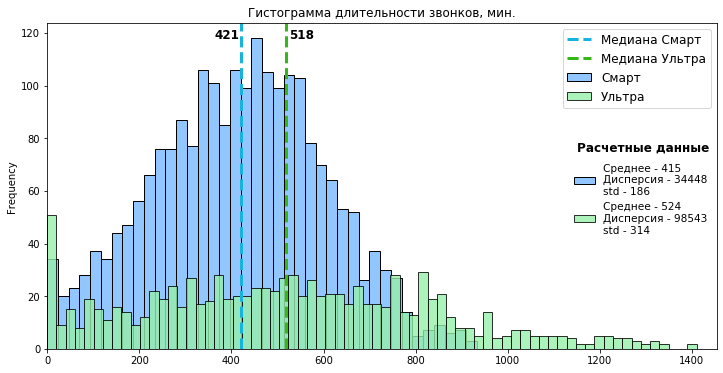

In [74]:
plot_hist_comparison('Звонки')

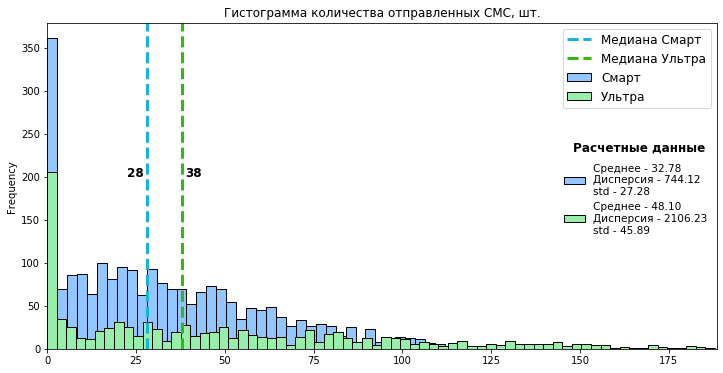

In [75]:
plot_hist_comparison('СМС')

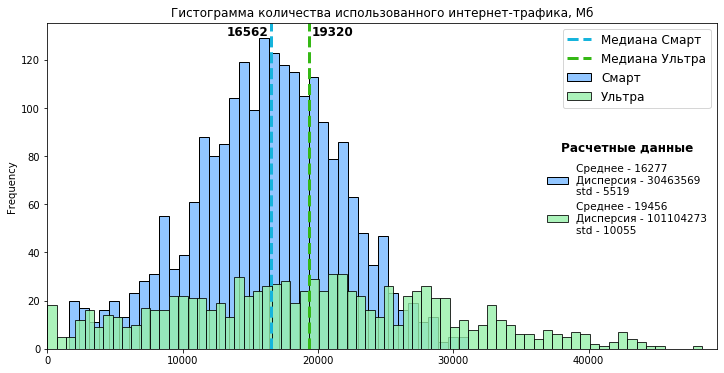

In [76]:
plot_hist_comparison('Интернет')

# 4. Проверка гипотезы.

* H0 (нулевая гипотеза) - предположение о том, что между данными у нас нет связи. В данном случае, что средняя выручка пользователей тарифа Смарт не отличается от средней выручки пользователей тарифа Ультра.
* H1 (альтернативная гипотеза) - средняя выручка пользователей тарифа Смарт отличается от средней выручки пользователей тарифа Ультра.H0 (нулевая гипотеза) - предположение о том, что между данными у нас нет связи. В данном случае, что средняя выручка пользователей тарифа Смарт не отличается от средней выручки пользователей тарифа Ультра.

Средняя выручка пользователей тарифов.

Text(0.5, 0.93, 'Boxplot по выручке с whis = 1,5')

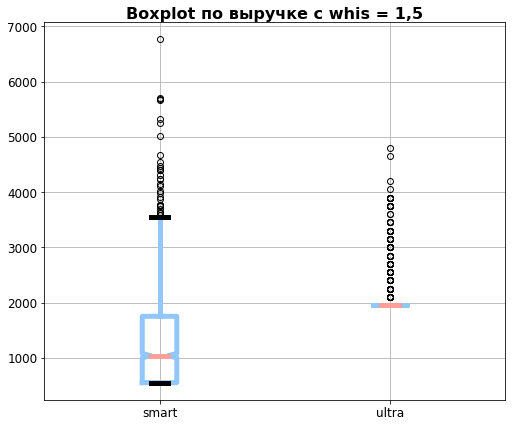

In [77]:
ax = data_event_numbers.boxplot(column='Сумма за месяц, руб.', by='Тариф', fontsize=12,
                                         boxprops=dict(linestyle='-', linewidth=5),
                                         medianprops=dict(linestyle='-', linewidth=5),
                                         whiskerprops=dict(linestyle='-', linewidth=5),
                                         capprops=dict(linestyle='-', linewidth=5),
                                         notch=True, figsize=(8,7))
ax.set_title('')
ax.title.set_size(40)
ax.set_xlabel('')
plt.suptitle('Boxplot по выручке с whis = 1,5', y=0.93, fontsize=16, fontweight='bold')
# Смотрим выбросы

In [78]:
revenue_int_smart, revenue_int_ultra = get_intervals('Сумма за месяц, руб.', 'Тариф')

Границы интервала для столбца "Сумма за месяц, руб." тарифа "Смарт": 0.0 - 3550.0
Границы интервала для столбца "Сумма за месяц, руб." тарифа "Ультра": 1950.0 - 1950.0


In [79]:
smart_mean_revenue = data_event_numbers[(data_event_numbers['Тариф'] == 'smart') &
                                      (data_event_numbers['Сумма за месяц, руб.'] >= revenue_int_smart[0]) &
                                      (data_event_numbers['Сумма за месяц, руб.'] <= revenue_int_smart[1])]['Сумма за месяц, руб.']

ultra_mean_revenue = data_event_numbers[(data_event_numbers['Тариф'] == 'ultra') &
                                      (data_event_numbers['Сумма за месяц, руб.'] >= revenue_int_ultra[0]) &
                                      (data_event_numbers['Сумма за месяц, руб.'] <= revenue_int_ultra[1])]['Сумма за месяц, руб.']

In [80]:
from scipy.stats import ttest_ind
stat, p = ttest_ind(smart_mean_revenue, ultra_mean_revenue)
print('t = {}\np-value = {:.10e}'.format(stat, p))
print('\nПороговое значение alpha = 0.05')

t = -27.932596508963062
p-value = 4.6244593529e-153

Пороговое значение alpha = 0.05


*Отвергаем нулевую гипотезу.*

In [81]:
print('Средняя выручка по пользователям тарифа "Смарт" - {:.2f}'.format(smart_mean_revenue.mean()))
print('Средняя выручка по пользователям тарифа "Ультра" - {}'.format(ultra_mean_revenue.mean()))

Средняя выручка по пользователям тарифа "Смарт" - 1249.74
Средняя выручка по пользователям тарифа "Ультра" - 1950.0


*Как и ожидалось средняя выручка по Ультре больше, чем по Смарту, т.к. абонентская плата выше в 3 раза.*

Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [82]:
data_event_numbers['is_Moscow'] = np.where(data_event_numbers['Город'] == 'Москва', 1, 0)

In [83]:
data_event_numbers.head()

,User_id,Время года,Месяц,"Кол-во звонков, шт.","Звонки, мин.","СМС, шт.","Интернет, Мб",Тариф,Город,Широта,Долгота,"Аб. плата, руб.",Минуты сверх,СМС сверх,Мб сверх,"Плата сверх лимита, руб.","Сумма за месяц, руб.",Не хватило тарифного плана,is_Moscow
0,1000,весна,5,17.0,159.0,22.0,2256.0,ultra,Краснодар,45.03547,38.975313,1950,0.0,0,0.0,0,1950,0,0
1,1000,зима,12,38.0,333.0,70.0,9827.0,ultra,Краснодар,45.03547,38.975313,1950,0.0,0,0.0,0,1950,0,0
2,1000,лето,6,28.0,172.0,60.0,23257.0,ultra,Краснодар,45.03547,38.975313,1950,0.0,0,0.0,0,1950,0,0
3,1000,лето,7,41.0,340.0,75.0,14016.0,ultra,Краснодар,45.03547,38.975313,1950,0.0,0,0.0,0,1950,0,0
4,1000,лето,8,42.0,408.0,81.0,14070.0,ultra,Краснодар,45.03547,38.975313,1950,0.0,0,0.0,0,1950,0,0


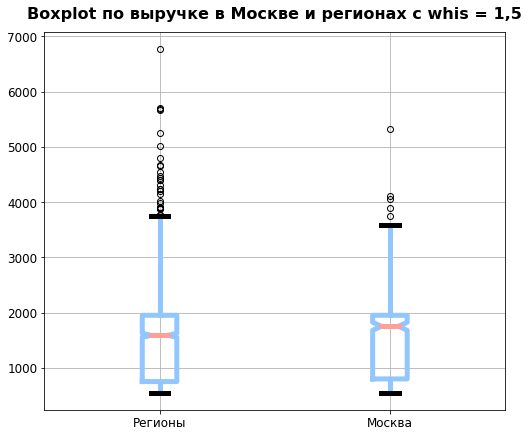

In [84]:
ax = data_event_numbers.boxplot(column='Сумма за месяц, руб.', by='is_Moscow', fontsize=12,
                                         boxprops=dict(linestyle='-', linewidth=5),
                                         medianprops=dict(linestyle='-', linewidth=5),
                                         whiskerprops=dict(linestyle='-', linewidth=5),
                                         capprops=dict(linestyle='-', linewidth=5),
                                         notch=True, figsize=(8,7))



labels = [item.get_text() for item in ax.get_xticklabels()]

labels[0] = 'Регионы'
labels[1] = 'Москва'

ax.set_xticklabels(labels)

plt.suptitle('Boxplot по выручке в Москве и регионах с whis = 1,5', y=0.95, fontsize=16, fontweight='bold')

ax.set_xlabel('')
ax.set_title('')
ax.title.set_size(40)

In [85]:
revenue_int_smart, revenue_int_ultra = get_intervals('Сумма за месяц, руб.', 'is_Moscow')

Границы интервала для столбца "Сумма за месяц, руб." для регионов: 550.0 - 3750.0
Границы интервала для столбца "Сумма за месяц, руб." для Москвы: 550.0 - 3678.0


In [86]:
moscow_revenue = data_event_numbers[(data_event_numbers['Город'] == 'Москва') &
                                  (data_event_numbers['Сумма за месяц, руб.'] >= revenue_int_smart[0]) &
                                  (data_event_numbers['Сумма за месяц, руб.'] <= revenue_int_smart[1])]['Сумма за месяц, руб.']

regions_revenue = data_event_numbers[(data_event_numbers['Город'] != 'Москва') &
                                  (data_event_numbers['Сумма за месяц, руб.'] >= revenue_int_ultra[0]) &
                                  (data_event_numbers['Сумма за месяц, руб.'] <= revenue_int_ultra[1])]['Сумма за месяц, руб.']

In [87]:
stat, p = ttest_ind(moscow_revenue, regions_revenue)
print('t = {}\np-value = {:.2}'.format(stat, p))
print('\nПороговое значение alpha = 0.05')

t = 1.49291699198228
p-value = 0.14

Пороговое значение alpha = 0.05


*Нулевую гипотезу не опровергнуть.*

In [88]:
print('Средняя выручка по пользователю в месяц в Москве: {:.2f}'.format(moscow_revenue.mean()))
print('Средняя выручка по пользователю в месяц в регионах: {:.2f}'.format(regions_revenue.mean()))

Средняя выручка по пользователю в месяц в Москве: 1532.38
Средняя выручка по пользователю в месяц в регионах: 1483.28


Средняя выручка по Москве больше на 49 рублей. Вполне логично, ибо плата за тариф одинакова во всех регионах, что не должно приводить к большой статистической разнице.

# 5. Итоговый вывод.

Посмотрим сколько лимита разных типов связи тратится в пределах тарифов.

In [89]:
smart_mean_internet = (data_event_numbers[(data_event_numbers['Тариф'] == 'smart')]['Интернет, Мб']/(1024 * 15)).mean()
print('Средний процент использования пакета интернет-трафика по тарифу "Смарт" - {:.2%} = {:,.0f} Гб'.
      format(smart_mean_internet, smart_mean_internet * 1024 * 15))
smart_mean_calls = (data_event_numbers[(data_event_numbers['Тариф'] == 'smart')]['Звонки, мин.']/(500)).mean()
print('Средний процент использования пакета минут по тарифу "Смарт" - {:.2%} = {:.2f} мин'.
      format(smart_mean_calls, smart_mean_calls * 500))
smart_mean_sms = (data_event_numbers[(data_event_numbers['Тариф'] == 'smart')]['СМС, шт.']/(50)).mean()
print('Средний процент использования пакета СМС по тарифу "Смарт" - {:.2%} = {:.0f} шт.'.
      format(smart_mean_sms, smart_mean_sms * 50))
print('---------------------------------------------------------------------------------')
ultra_mean_internet = (data_event_numbers[(data_event_numbers['Тариф'] == 'ultra')]['Интернет, Мб']/(1024 * 30)).mean()
print('Средний процент использования пакета интернет-трафика по тарифу "Ультра" - {:.2%} = {:,.0f} Гб'.
      format(ultra_mean_internet, ultra_mean_internet * 1024 * 30))
ultra_mean_calls = (data_event_numbers[(data_event_numbers['Тариф'] == 'ultra')]['Звонки, мин.']/(3000)).mean()
print('Средний процент использования пакета минут по тарифу "Ультра" - {:.2%} = {:.2f} мин'.
      format(ultra_mean_calls, ultra_mean_calls * 3000))
ultra_mean_sms = (data_event_numbers[(data_event_numbers['Тариф'] == 'ultra')]['СМС, шт.']/(1000)).mean()
print('Средний процент использования пакета СМС по тарифу "Ультра" - {:.2%} = {:.0f} шт.'.
      format(ultra_mean_sms, ultra_mean_sms * 1000))

Средний процент использования пакета интернет-трафика по тарифу "Смарт" - 105.66% = 16,229 Гб
Средний процент использования пакета минут по тарифу "Смарт" - 83.59% = 417.93 мин
Средний процент использования пакета СМС по тарифу "Смарт" - 66.77% = 33 шт.
---------------------------------------------------------------------------------
Средний процент использования пакета интернет-трафика по тарифу "Ультра" - 63.43% = 19,487 Гб
Средний процент использования пакета минут по тарифу "Ультра" - 17.55% = 526.62 мин
Средний процент использования пакета СМС по тарифу "Ультра" - 4.94% = 49 шт.


Посмотрим какие переплаты осуществляются на дополнительные пакеты видов связи.

In [90]:
smart_over_mean_internet = data_event_numbers[(data_event_numbers['Тариф'] == 'smart')]['Мб сверх'].mean()
smart_over_mean_internet_rub = np.round(smart_over_mean_internet, -3)/1000 * 200
print('Среднее превышение пакета интернет по тарифу "Смарт" - {:.0f} Мб на сумму - {:.0f} руб.'.
      format(smart_over_mean_internet, smart_over_mean_internet_rub))

smart_over_mean_calls = np.ceil(data_event_numbers[(data_event_numbers['Тариф'] == 'smart')]['Минуты сверх'].mean())
smart_over_mean_calls_rub = smart_over_mean_calls * 3
print('Среднее превышение пакета минут по тарифу "Смарт" - {:.0f} мин на сумму - {:.0f} руб.'.
      format(smart_over_mean_calls, smart_over_mean_calls_rub))

smart_over_mean_sms = np.ceil(data_event_numbers[(data_event_numbers['Тариф'] == 'smart')]['СМС сверх'].mean())
smart_over_mean_sms_rub = smart_over_mean_sms * 3
print('Среднее превышение пакета СМС по тарифу "Смарт" - {:.0f} шт. на сумму - {:.0f} руб.'.
      format(smart_over_mean_sms, smart_over_mean_sms_rub))

print('----------------------------------------------------------------')

ultra_over_mean_internet = data_event_numbers[(data_event_numbers['Тариф'] == 'ultra')]['Мб сверх'].mean()
ultra_over_mean_internet_rub = np.round(ultra_over_mean_internet, -3)/1000 * 150
print('Среднее превышение пакета интернет по тарифу "Ультра" - {:.0f} Мб на сумму - {:.0f} руб.'.
      format(ultra_over_mean_internet, ultra_over_mean_internet_rub))

ultra_over_mean_calls = np.ceil(data_event_numbers[(data_event_numbers['Тариф'] == 'ultra')]['Минуты сверх'].mean())
ultra_over_mean_calls_rub = ultra_over_mean_calls * 3
print('Среднее превышение пакета минут по тарифу "Ультра" - {:.0f} мин на сумму - {:.0f} руб.'.
      format(ultra_over_mean_calls, ultra_over_mean_calls_rub))

ultra_over_mean_sms = np.ceil(data_event_numbers[(data_event_numbers['Тариф'] == 'ultra')]['СМС сверх'].mean())
ultra_over_mean_sms_rub = ultra_over_mean_sms * 3
print('Среднее превышение пакета СМС по тарифу "Ультра" - {:.0f} шт. на сумму - {:.0f} руб.'.
      format(ultra_over_mean_sms, ultra_over_mean_sms_rub))

Среднее превышение пакета интернет по тарифу "Смарт" - 2771 Мб на сумму - 600 руб.
Среднее превышение пакета минут по тарифу "Смарт" - 42 мин на сумму - 126 руб.
Среднее превышение пакета СМС по тарифу "Смарт" - 6 шт. на сумму - 18 руб.
----------------------------------------------------------------
Среднее превышение пакета интернет по тарифу "Ультра" - 755 Мб на сумму - 150 руб.
Среднее превышение пакета минут по тарифу "Ультра" - 0 мин на сумму - 0 руб.
Среднее превышение пакета СМС по тарифу "Ультра" - 0 шт. на сумму - 0 руб.


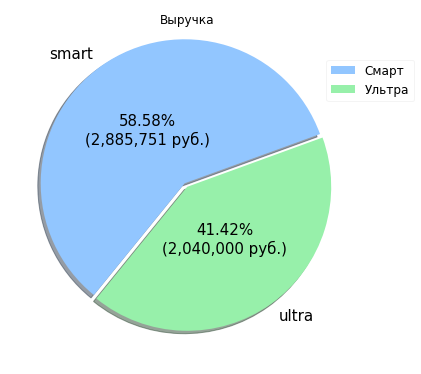

In [91]:
all_revenue = data_event_numbers['Сумма за месяц, руб.'].sum()


def func_pct(pct):
    value = float(pct/100.*all_revenue)
    return "{:.2f}%\n({:,.0f} руб.)".format(pct, value)

explode = (0.03, 0) 

axes = data_event_numbers.groupby('Тариф')['Сумма за месяц, руб.'].sum().plot(kind='pie', subplots=True, fontsize=15,
                                                                     use_index=False, shadow=True, explode=explode,
                                                                     title = 'Выручка', pctdistance=0.45,
                                                                     startangle=20, figsize=(20,5),
                                                                     autopct=lambda pct: func_pct(pct))

for ax in axes:
    ax.legend(['Смарт', 'Ультра'], bbox_to_anchor=(0.87,0.87), framealpha=0.2, prop={'size':12})
    ax.set_ylabel('')
    
ax.title.set_size(40)
plt.tight_layout(pad=0)

Тариф Смарт приносит около 60% всей выручки, но при этом на него приходится 2200 пользователей.
Тариф Ультра дает остальные 40%, но эту выручку генерируют всего 1000 пользователей.
Среднему пользователю тарифа Смарт не хватает 2 Гб интернета к заложенными в абонентскую плату 15 Гб и ему приходится дозаказывать эти 2 Гб и доплачивать за них 400 рублей.
Если рассматривать только тех пользователей Смарт, кто вылезает за лимиты по интернет-трафику, то средний размер доп. заказа интернет-трафика равен 3 Гб, за которые они платят 600 рублей.
Таким образом, в тарифной сетке есть дешевый тариф Смарт за 550 рублей, где пользователю не хватает интернета и количество использованных минут разговора приближается к границе (418 мин из 500), и есть тариф Ультра, стоимостью 1950 рублей, которым пользуется уже другой класс людей, где лимитов по всем типам связи предостаточно (иногда дозаказывают в среднем 1 Гб интернета).

Итог: телеоператору надо подумать и выработать промежуточное решение, которое позволяло бы клиенту более комфортно, без доп. заказов, пользоваться услугами связи (особенно мобильным интернетом), при этом по цене являлось бы промежуточным вариантом между текущими Смарт и Ультра. Учитывая то, что средний пользователь тарифа Смарт дозаказывает 2 Гб на 400 рублей, т.е. платит в итоге 550 + 400 = 950 рублей за месяц, это значит, что эти деньги клиент готов тратить в месяц в качестве абонентской платы. Например, можно рассмотреть вариант создания тарифа, в дополнение к текущим, который был бы создан на основе тарифа Смарт, но с пакетом интернет-трафика в 20 Гб и стоимостью 950 рублей. Для большего привлечения внимания к тарифу можно расширить пакет минут и пакет СМС с 500-50 до 750 и 100 соответственно. Компания в плане выручки не потеряет, т.к. средний пользователь не дозаказывает эти услуги, но при этом заставит выглядеть предложение выгодней.